In [1]:
from pathlib import Path
import exifread
import matplotlib.image
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
import astropy.units as u
from sunpy.time import parse_time
import sunpy.coordinates
import sunpy.coordinates.sun
from astropy.constants import R_earth
from astropy.coordinates import CartesianRepresentation, EarthLocation, SkyCoord
import math
from scipy import ndimage
from skimage.transform import hough_circle, hough_circle_peaks
from matplotlib.patches import Circle
from astropy.coordinates import CartesianRepresentation, EarthLocation, SkyCoord
from sunpy.map.header_helper import make_fitswcs_header
from skimage.feature import peak_local_max
from astropy.time import Time
from sunpy.coordinates import frames
from sunpy.coordinates import sun
import os
import random
import rawpy
import imageio
from astropy.io import fits
import csv
from timezonefinder import TimezoneFinder
from datetime import datetime, timedelta
from PIL import Image
import csv
# import exiv2
import time
from astropy.io import fits
from astropy.time import Time
import exifread
import rawpy
import imageio
import csv
from datetime import datetime, timedelta
from timezonefinder import TimezoneFinder
import pytz

F:\rotation_eclipse\jupyter\py310_work_version\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#!pip install exiv2
#!pip install pyexiftool


def getTime(image_path):
    if image_path.split('.')[-1] in raw_types:
        return getTimeWeird(image_path)

    if image_path.split('.')[-1] == 'fits':
        with fits.open(image_path) as hdul:
            header = hdul[0].header
            if "DATE-OBS" in header:
                obs_time_str = header["DATE-OBS"]
                obs_time = Time(obs_time_str)
                return obs_time
    
    exif = Image.open(image_path).getexif()
    if not exif:
        print('uh oh')
    return exif[306]

def getLatLon(userID):
    with open('data.csv', mode='r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            if row[0] == userID:
                return float(row[1]), float(row[2])

def getTimeWeird(image_path):
    try:
        stat = os.stat(image_path)
        print(stat)
        # creation_time = stat.st_ctime
        creation_time = stat.st_mtime #time last modified
        
        return time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(creation_time))
    except FileNotFoundError:
        return "File not found"

im = '../24_images/R_2eJ8rlmbu9gZfGx/_DSF3921.RAF'
getTimeWeird(im)

os.stat_result(st_mode=33206, st_ino=160714195136, st_dev=1663968962, st_nlink=1, st_uid=0, st_gid=0, st_size=15037616, st_atime=1728010826, st_mtime=1712695374, st_ctime=1728010827)


'2024-04-09 13:42:54'

In [3]:
#KEEPING THIS TO REFERENCE LATER

# # SOLAR_ECLIPSE_IMAGE = '1.jpg'
# # lat = 44.46408277777778 
# # lon = 115.99248277777778
# # time = Time('2017-08-21T11:27:00')
# #--Hy
# # SOLAR_ECLIPSE_IMAGE = '24_images/R_32LU6pKyipqNvLD/IMG_4772.cr2'
# # lat = 29.22697
# # lon = -100.892
# # alt = 0
# # time = parse_time("2024-04-08 12:28:00")
# #--Kevin Ring
# # SOLAR_ECLIPSE_IMAGE = '24_images/DSC_3756.nef'
# # lat = 30.53728
# # lon = 98.35742
# # alt = 0
# # time = parse_time("2024-04-08 1:37:00")


# # --Updated Hy, this references the csv and will be used long term
# # folder = '24_images/R_32LU6pKyipqNvLD/'
# # user = 'R_32LU6pKyipqNvLD'
# # user = 'R_1Jbdw0E8TUxdKWM' #cr3
# # user = 'R_2eJ8rlmbu9gZfGx' #raf
# # user = 'R_6hy6qqKQPq05yc0' #fits, there's issues with this

# # user = 'R_3rZCcwsix3oIlBH' #This one has a very clear solar prominence to make sure adjustments are correct
# # user = 'R_2eJ8rlmbu9gZfGx' #maybe wrong, idk



# # user = 'R_7jGQA5ayN3PAhaf'


# user = 'R_2eJ8rlmbu9gZfGx' #raf
# file_name = '_DSF4100.RAF'

# # user = 'R_5dhtl8su64RaocV'
# # file_name = '481A5060.CR2'


# user = 'R_6hy6qqKQPq05yc0'
# file_name = 'Derek_Richardson_2024-04-08_14-00-25__28.00_0.40s_0001.fits'


# raw = ['CR3', 'RAF', 'ARW', 'nef']
# all_images = os.listdir('24_images/' + user)
# # file_name = all_images[random.randint(0,len(all_images)-1)]
# # file_name = '_DSF4100.RAF'
# # file_name = 'IMG_5628.CR2'
# # file_name = all_images[2]

# SOLAR_ECLIPSE_IMAGE = '24_images/' + user + '/' + file_name
# print(SOLAR_ECLIPSE_IMAGE)
# time = getTime(SOLAR_ECLIPSE_IMAGE)

# if SOLAR_ECLIPSE_IMAGE.split('.')[-1] != 'fits':
#     date, time = time.split(' ')
#     date = date.replace(':','-')
#     time = parse_time(date + ' ' + time)

# print(time)
# print(f'expected time: 4/8/2024 3:18pm')

# # time = '2024-04-08T12:13:00.000'
# # time = '2024-04-08T16:38:38.000'
# # time = '2024-04-08T12:13:38.000'

# time = '2024-04-08T15:18:38.000'
# time = parse_time(time)
# print(time)

# #Times provided are (should be) in local time, where they took the images
# #It may be the move to just go get time created and put it in the spreadsheet

# lat, lon = getLatLon(user)
# print(f'lat:{lat}, lon:{lon}, time:{time}, file:{SOLAR_ECLIPSE_IMAGE}')

In [4]:
#!pip install timezonefinder



def readCSV(user):
    '''
        Read the data.csv file and get the lat, lon, and time stored there
        user<string>: name of the user ID associated with the upload
    '''
    with open('data.csv', mode='r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            if row[0] == user:
                return float(row[1]), float(row[2]), parse_time(row[3]), parse_time(row[4])
    return 0,0,0

# def getTimezone(lat,lon):
#     tf = TimezoneFinder()
    
#     with open('data.csv', newline='') as csvfile:
#         reader = csv.DictReader(csvfile)

#         for row in reader:
#             latitude = float(row['Latitude'])
#             longitude = float(row['Longitude'])
            
#             # Step 4: Find the timezone for each coordinate
#             timezone = tf.timezone_at(lng=longitude, lat=latitude)
            
#             # Step 5: Print the results
#             print(f"ResponseID: {row['ResponseID']}, Timezone: {timezone}")
            
#             print(row['LocalTime'], type(row['LocalTime']))
            # if timezone == 'America/Indiana/Indianapolis':
            #     print('+4')
            #     print(datetime.strptime(row['LocalTime'], '%Y-%m-%dT%H:%M:%S') + timedelta(hours=4))
    
    
    # timezone = tf.timezone_at(lng=lon, lat=lat)
    # print(timezone)
    

# latitude = 40.018
# longitude = -85.310
# time_str = "2024-04-08T15:07:00"

# getTimezone(latitude, longitude)

#Totallity begins at ~16:38 UTC

#America/Chicago -5hr
#America/Indiana/Indianapolis -4hr
#America/Toronto -4hr
#America/New_York -4hr
#America/Matamoros -5hr
#America/Monterrey -6hr
#America/Mazatlan -7hr

#2024-04-08T13:37:00Z for R_3rZCcwsix3oIlBH
#I made change to the time here and it seems to be a bit more reasonable from what I was getting before
#R_32LU6pKyipqNvLD,29.22697,-100.89242,2024-04-08T12:28:00Z

#I'm hitting a wall, the goal right now is to make sure all the times are propery adjusted, Ive only done one or two so far


In [5]:
def readCSVwFile(file_name):
    '''
        Read the data.csv file and get the lat, lon, and time stored there
        user<string>: name of the user ID associated with the upload
    '''
    with open('test_exif/data_w_times.csv', mode='r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            if row[1] == file_name:
                return float(row[2]), float(row[3]), parse_time(row[4]), parse_time(row[5])
    return False

# The below was used to set UTC values for the csv, does not need to be ran again

In [6]:
# def getTimezone(lat, lon):
#     tf = TimezoneFinder()
#     return tf.timezone_at(lng=lon, lat=lat)

# def convert_to_utc(local_time_str, timezone_str):
#     local_time = datetime.strptime(local_time_str, '%Y-%m-%dT%H:%M:%S')
#     local_tz = pytz.timezone(timezone_str)
#     local_dt = local_tz.localize(local_time)
#     utc_dt = local_dt.astimezone(pytz.utc)
#     return utc_dt.strftime('%Y-%m-%dT%H:%M:%SZ')

# with open('data.csv', newline='') as csvfile:
#     reader = csv.DictReader(csvfile)
#     rows = list(reader)

# with open('data.csv', 'w', newline='') as csvfile:
#     fieldnames = reader.fieldnames + ['UTC']
#     writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#     writer.writeheader()

#     for row in rows:
#         latitude = float(row['Latitude'])
#         longitude = float(row['Longitude'])
#         local_time = row['LocalTime']
        
#         timezone = getTimezone(latitude, longitude)
#         if timezone:
#             utc_time = convert_to_utc(local_time, timezone)
#             row['UTC'] = utc_time
#         else:
#             row['UTC'] = 'Unknown'
        
#         writer.writerow(row)

In [7]:
all_users = os.listdir('../24_images')

raw_types = ['CR3','cr3', 'RAF', 'ARW', 'nef']
print(len(all_users))
user = all_users[9]
#14, the fits one is a problem, not detecting any circles
#17 having problems reading image
all_images = os.listdir('../24_images/' + user)
file_name = all_images[len(all_images)//2]
SOLAR_ECLIPSE_IMAGE = '../24_images/' + user + '/' + file_name
print(SOLAR_ECLIPSE_IMAGE)
# lat, lon, time, utc = readCSV(user)
lat, lon, time, utc = readCSVwFile(file_name)
time = utc
print(f'lat:{lat}, lon:{lon}, time:{time}, utc:{utc}, file:{SOLAR_ECLIPSE_IMAGE}')

23
../24_images/R_7Pc9Yj1CmydXAMu/IMG_0933.CR3
lat:32.8399, lon:-96.72381, time:2024-04-08T17:41:59.000, utc:2024-04-08T17:41:59.000, file:../24_images/R_7Pc9Yj1CmydXAMu/IMG_0933.CR3


In [8]:
if SOLAR_ECLIPSE_IMAGE.split('.')[-1] in raw_types:
    with rawpy.imread(SOLAR_ECLIPSE_IMAGE) as raw:
        rgb_image = raw.postprocess()
    im_rgb = np.flipud(rgb_image) #flips upside down for some reason?
    im = np.dot(im_rgb[...,:3], [0.2989, 0.5870, 0.1140]) 
elif SOLAR_ECLIPSE_IMAGE.split('.')[-1] == 'fits':
    with fits.open(SOLAR_ECLIPSE_IMAGE) as hdul:
        im = hdul[0].data
else:
    im_rgb = np.flipud(matplotlib.image.imread(SOLAR_ECLIPSE_IMAGE))
    im = rgb2gray(im_rgb)

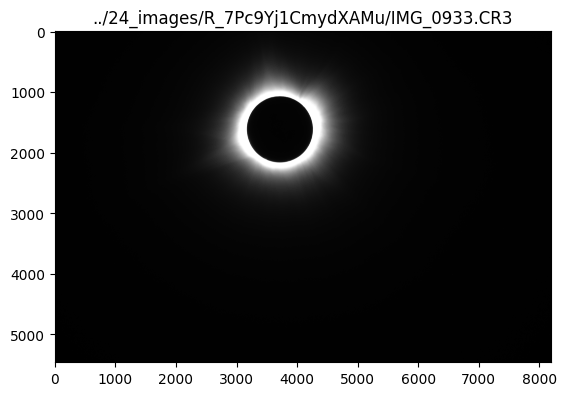

In [9]:
im = np.array(im)
plt.imshow(im, cmap="gray")
plt.title(SOLAR_ECLIPSE_IMAGE)
plt.show()

# Find The Moon

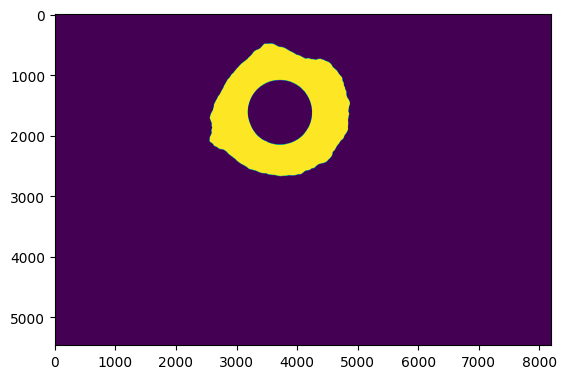

In [10]:
blur_im = ndimage.gaussian_filter(im, 8)
mask = blur_im > blur_im.mean() * 3
plt.imshow(mask)
plt.show()

In [11]:
label_im, nb_labels = ndimage.label(mask)
slice_y, slice_x = ndimage.find_objects(label_im == 1)[0]
roi = blur_im[slice_y, slice_x]

In [12]:
sx = ndimage.sobel(roi, axis=1, mode="constant")
sy = ndimage.sobel(roi, axis=0, mode="constant")
sob = np.hypot(sx, sy)

In [13]:
hough_radii = np.arange(np.floor(np.mean(sob.shape) / 4), np.ceil(np.mean(sob.shape) / 2), 10)
hough_res = hough_circle(sob > (sob.mean() * 5), hough_radii)

# Select the most prominent circle
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)
print(accums, cx, cy, radii)

[0.47869674] [1185] [1114] [563.]


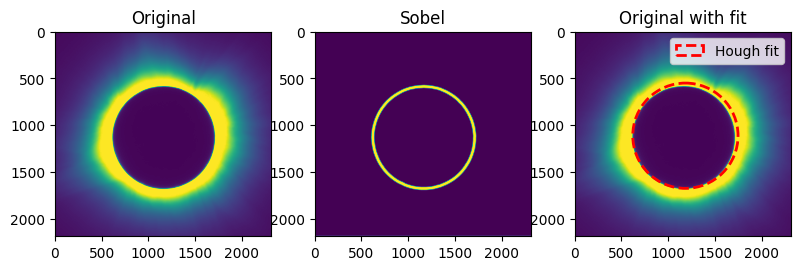

In [14]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(9.5, 6))
ax[0].imshow(im[slice_y, slice_x])
ax[0].set_title("Original")
ax[1].imshow(sob > (sob.mean() * 5))
ax[1].set_title("Sobel")
circ = Circle(
    [cx, cy], radius=radii, facecolor="none", edgecolor="red", linewidth=2, linestyle="dashed", label="Hough fit"
)
ax[2].imshow(im[slice_y, slice_x])
ax[2].add_patch(circ)
ax[2].set_title("Original with fit")
plt.legend()
plt.show()

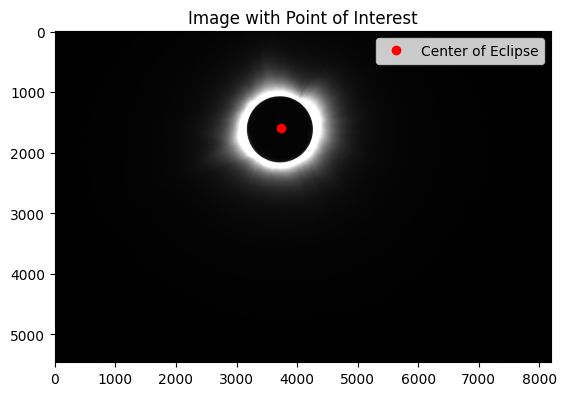

In [15]:
#pixel values for the center of the moon
im_cx = (cx[0] + slice_x.start) * u.pix
im_cy = (cy[0] + slice_y.start) * u.pix
im_radius = radii[0] * u.pix

plt.figure()
plt.imshow(im, cmap='gray')
plt.plot(im_cx, im_cy, 'ro', label='Center of Eclipse')  # 'ro' means red color and circle marker
plt.legend()
plt.title('Image with Point of Interest')
plt.show()

# SunPy Map & Fits file

In [16]:
loc = EarthLocation(lat=lat, lon=lon, height=0)
observer = loc.get_itrs(time)

In [17]:
moon = SkyCoord(sunpy.coordinates.get_body_heliographic_stonyhurst("moon", time, observer=observer))
R_moon = 0.2725076 * R_earth  # IAU mean radius
dist_moon = SkyCoord(observer).separation_3d(moon)
moon_obs = np.arcsin(R_moon / dist_moon).to("arcsec")
print(moon_obs)

INFO: Apparent body location accounts for 1.18 seconds of light travel time [sunpy.coordinates.ephemeris]
1012.4592282570193 arcsec


In [18]:
plate_scale = moon_obs / im_radius
print(plate_scale)

1.7983290022327163 arcsec / pix


In [19]:
solar_rotation_angle = sunpy.coordinates.sun.orientation(loc, time)
print(solar_rotation_angle)

4d40m54.6384677s


In [20]:
frame = sunpy.coordinates.Helioprojective(observer=observer, obstime=time)
moon_hpc = moon.transform_to(frame)

header = make_fitswcs_header(
    im,
    moon_hpc,
    reference_pixel=u.Quantity([im_cx, im_cy]),
    scale=u.Quantity([plate_scale, plate_scale]),
    rotation_angle=solar_rotation_angle,
)

In [21]:
eclipse_map = sunpy.map.Map(im, header)

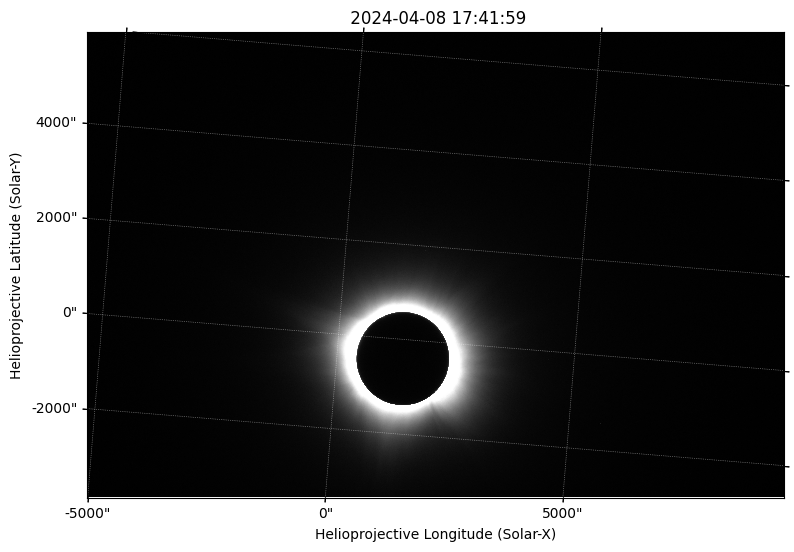

In [22]:
#Sanity plot
fig = plt.figure(figsize=(9, 9))
ax = plt.subplot(projection=eclipse_map)
eclipse_map.plot(axes=ax)
plt.show()

In [23]:
obs_location = SkyCoord(lon * u.deg, lat * u.deg, frame=frames.HeliographicStonyhurst, obstime=time)
# Calculate the position of solar north
solar_north_angle = sun.P(time)
solar_north_coord = SkyCoord(0 * u.arcsec, 0 * u.arcsec, frame=eclipse_map.coordinate_frame)
solar_north_coord = solar_north_coord.transform_to(frames.Helioprojective(observer=obs_location))
solar_north_coord = solar_north_coord.directional_offset_by(solar_north_angle, 1000 * u.arcsec)

In [24]:
solar_north_pixel = eclipse_map.world_to_pixel(solar_north_coord)
print(solar_north_pixel)

PixelPair(x=<Quantity 2535.60490905 pix>, y=<Quantity 2235.08009719 pix>)


Solar North Pixel Coordinates: (2535.6049090539136, 2235.0800971933186)


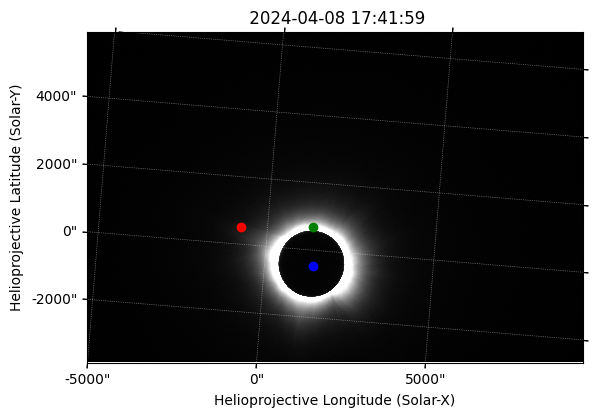

In [25]:
# Extract the numerical values from the quantities
solar_north_x = solar_north_pixel.x.to_value()
solar_north_y = solar_north_pixel.y.to_value()

plt.figure()
eclipse_map.plot()
plt.plot(solar_north_x, solar_north_y, 'ro', label='Solar North')
plt.plot(im_cx, im_cy, 'bo', label='Center of Eclipse')  # 'ro' means red color and circle marker
plt.plot(im_cx, solar_north_y, 'go', label="other point")
print(f"Solar North Pixel Coordinates: ({solar_north_x}, {solar_north_y})")

plt.show()

The angle between the points is 61.98 degrees
Solar North Pixel Coordinates: (2535.6049090539136, 2235.0800971933186)


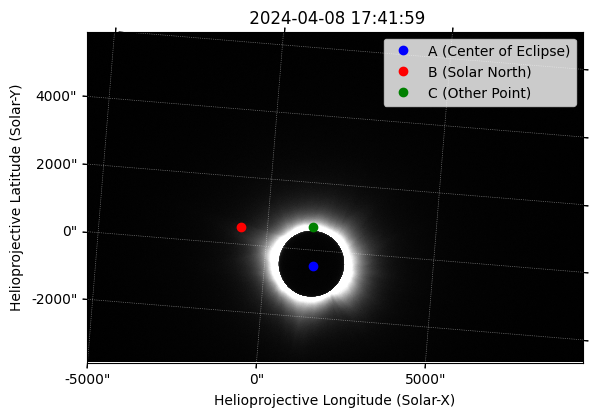

In [26]:
# Ensure the quantities are converted to dimensionless scalars
solar_north_x_value = solar_north_pixel.x.to_value(u.pix)
solar_north_y_value = solar_north_pixel.y.to_value(u.pix)
im_cx_value = im_cx.to_value(u.pix)
im_cy_value = im_cy.to_value(u.pix)

# Define the points using the dimensionless values
A = np.array([im_cx_value, im_cy_value])
B = np.array([solar_north_x_value, solar_north_y_value])
C = np.array([im_cx_value, solar_north_y_value])

# Calculate the vectors
AB = B - A
AC = C - A

# Calculate dot product
dot_product = np.dot(AB, AC)

# Calculate magnitudes
magnitude_AB = np.linalg.norm(AB)
magnitude_AC = np.linalg.norm(AC)

# Calculate cosine of the angle
cos_angle = dot_product / (magnitude_AB * magnitude_AC)

# Calculate the angle in radians
angle_radians = np.arccos(cos_angle)

# Convert the angle to degrees
angle_degrees = np.degrees(angle_radians)

print(f"The angle between the points is {angle_degrees:.2f} degrees")

# Plotting
plt.figure()
eclipse_map.plot()

plt.plot(im_cx, im_cy, 'bo', label='A (Center of Eclipse)') 
plt.plot(solar_north_x, solar_north_y, 'ro', label='B (Solar North)') # 'ro' means red color and circle marker
plt.plot(im_cx, solar_north_y, 'go', label="C (Other Point)")

plt.legend()

print(f"Solar North Pixel Coordinates: ({solar_north_x}, {solar_north_y})")

plt.show()

61.982169743129134
moon 3731.0 pix 1599.0 pix
solar north 2535.6049090539136 2235.0800971933186
other point 3731.0 pix 2235.0800971933186
rotation angle: 61.982169743129134
Solar north in the image is 61.982169743129134 degree counter clockwise rotation from the top of the image
../24_images/R_7Pc9Yj1CmydXAMu/IMG_0933.CR3


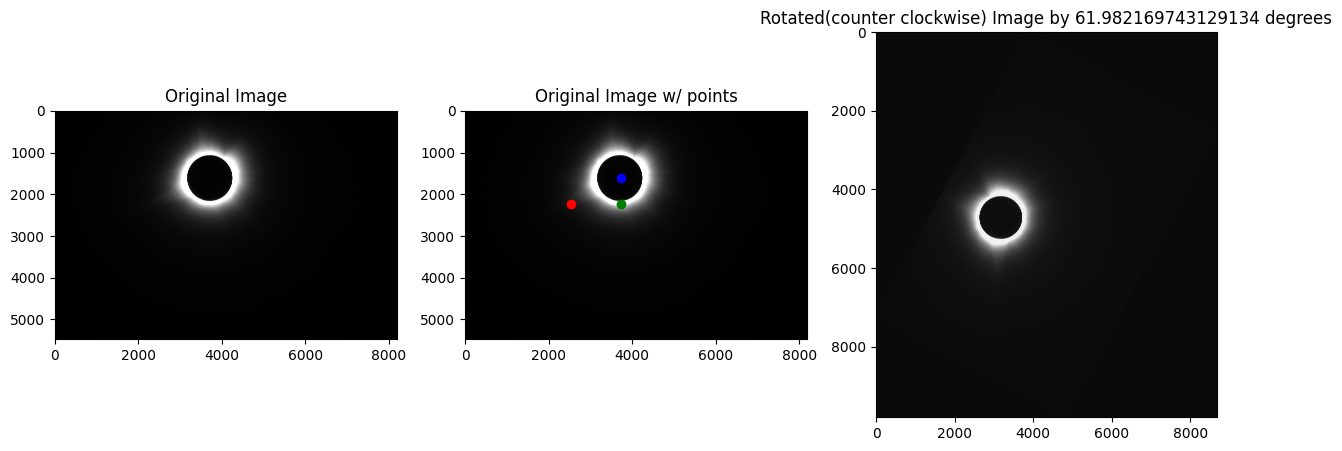

In [27]:
from scipy.ndimage import rotate #This package rotates counter-clockwise as default for some reason, so to go clockwise it has to be multipled by -1
rotation_angle = angle_degrees

#rotation_angle = rotation_angle #I thought about adding some adjustment here to get it where it needs to go

print(rotation_angle)
print('moon',im_cx, im_cy)
print('solar north',solar_north_x, solar_north_y)
print('other point',im_cx, solar_north_y)

# if im_cy_value > solar_north_y_value:
#     print('expected north is too low, adjusting')
#     rotation_angle = rotation_angle - 180
# else:
#     print('expected north is at top')
#     rotation_angle = rotation_angle * -1

print(f'rotation angle: {rotation_angle}')

rotated_image = rotate(im, rotation_angle, reshape=True)

print(f'Solar north in the image is {rotation_angle} degree counter clockwise rotation from the top of the image')

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)

print(SOLAR_ECLIPSE_IMAGE)
plt.title(f'Original Image')
plt.imshow(im, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Original Image w/ points")
plt.imshow(im, cmap='gray')
plt.plot(im_cx, im_cy, 'bo', label='Center of Eclipse')  # 'ro' means red color and circle marker
plt.plot(solar_north_x, solar_north_y, 'ro', label='Solar North') # 'ro' means red color and circle marker
plt.plot(im_cx, solar_north_y, 'go', label="Other Point")


plt.subplot(1, 3, 3)
plt.title(f"Rotated(counter clockwise) Image by {rotation_angle} degrees")
plt.imshow(rotated_image, cmap='gray')

plt.show()

# Add information to output csv

In [28]:
# def reset():
#     with open('out.csv', mode='w') as file:
#         csv_writer = csv.writer(file)
#         csv_writer.writerow(['Folder', 'FileName', 'Angle'])

# def addToCSV(user_id, file_name, angle):
#     with open('out.csv', mode='a') as file:
#         csv_writer = csv.writer(file)
#         csv_writer.writerow([user_id, file_name, angle])

# reset()
# addToCSV(user, file_name, rotation_angle)